<a href="https://colab.research.google.com/github/basolu/Basolu-Machine-Learning/blob/main/user_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run training (yes-1 \ no-0)?0
Dataset loaded
Loaded model from disk
Train_data_pred shape: (4416, 128, 6)
Train_mae_loss shape: (6, 4416)
Test_data_pred shape: (4936, 128, 6)
Test_mae_loss shape: (6, 4936)
Anomalies's shape: (6, 4936)
Anomalies's shape (6, 4936)
Index_anomalies.shape: (4936,)
Number of anomalies: 4177
False Negative: 0 False Positive: 4686 True Negative: 4 True Positive: 246
Accuracy: 5.065856129685916


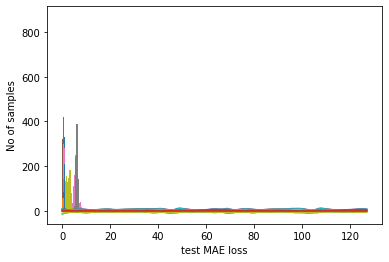

In [9]:
import tensorflow as tf
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.models import model_from_json
import numpy as np
import os
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from numpy import save
from math import*
from sklearn.metrics import classification_report
from keras.models import Model
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.interpolate import CubicSpline      # for warping
import warnings
warnings.filterwarnings('ignore')
import collections

action = int(input("Run training (yes-1 \ no-0)?"))

def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
  filepath = prefix + group + '/Inertial Signals/'
  # load all 6 files as a single array
  filenames = list()
  # total acceleration
  filenames += [group+'_acc_x.txt', group+'_acc_y.txt', group+'_acc_z.txt']
  # body acceleration
  filenames += [group+'_gyr_x.txt', group+'_gyr_y.txt', group+'_gyr_z.txt']
  # load input data
  X = load_group(filenames, filepath)
  # load class output
  y = load_file(prefix + group + '/y_'+group+'.txt')
  return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
  # load all train
  trainX, trainy = load_dataset_group('train', prefix + 'drive/MyDrive/Dataset_2/')
  #print("Shape trainX and trainy:", trainX.shape, trainy.shape)
  # load all test
  testX, testy = load_dataset_group('test', prefix + 'drive/MyDrive/Dataset_2/')
  subjects = read_csv('drive/MyDrive/Dataset_2/train/y_train.txt', header=None, delim_whitespace=True)
  # zero-offset class values
  trainy = trainy - 1
  testy = testy - 1
  # one hot encode y
  trainy = to_categorical(trainy)
  testy = to_categorical(testy)
  #print("Shape train and test:",trainX.shape, trainy.shape, testX.shape, testy.shape)
  #print(trainX.shape[1], trainX.shape[2], trainy.shape[1]) 
  return trainX, trainy, testX, testy

def autoencoder_model(X):
  trainX = X
  model = Sequential(
  [
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=trainX.shape[2], kernel_size=7, padding="same"),
  ]
)
  return model

#training-set for user 3's walking
def fun_train_test():
  trainX, trainy, testX, testy = load_dataset()
  subject = read_csv("drive/MyDrive/Dataset_2/train/y_train.txt", header=None, delim_whitespace=True)
  size = 0 #to determinate array's size
  #for the training set, only target's walks (subject 3 now)
  for i in range(0, len(subject)):
    if (subject[0][i] == 1): 
      size += 1
  
  train_data = np.empty([int (size), trainX.shape[1], trainX.shape[2]])
  number_train = 0
  for i in range(0, len(subject)):
    if (subject[0][i] == 1):
      #taking only ther subject's samples
      train_data[number_train] = trainX[i]
      number_train += 1

  print("Train size:", number_train)
  #saving sets
  np.save('drive/MyDrive/Dataset_2/train_data.npy', train_data)
  return train_data

def run_training():
  trainX, trainy, testX, testy = load_dataset()
  train_data = fun_train_test()
  train_jitter = DA_Jitter(train_data, 0.05) #augmentation
  train_data = np.concatenate((train_data, train_jitter), axis = 0)
  np.save('drive/MyDrive/Dataset_2/train_data.npy', train_data)
  # np.save('drive/MyDrive/Dataset_1/test_data.npy', test_data)
  model = autoencoder_model(train_data)
  model.compile(optimizer='adam', loss='mae', metrics='accuracy')
  #model.summary()
  nb_epochs = 50
  batch_size = 10
  history = model.fit(train_data, train_data, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history
  print("Training completed")
  #save the trained model
  model_json = model.to_json()
  with open("drive/MyDrive/Dataset_2/model_target.json", "w") as json_file:
    json_file.write(model_json)
  #serialize weights to HDF5
  model.save_weights("drive/MyDrive/Dataset_2/model_target.h5")
  print("Saved model to disk")

def detect_anomalies():
  trainX, trainy, test_data, testy = load_dataset()
  train_data = np.load('drive/MyDrive/Dataset_2/train_data.npy')
  # test_data  = np.load('drive/MyDrive/Dataset_1/test_data.npy')
  print("Dataset loaded")
  # print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  json_file = open("drive/MyDrive/Dataset_2/model_target.json", "r")
  loaded_model_json = json_file.read()
  json_file.close()
  #load model from a json model
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights("drive/MyDrive/Dataset_2/model_target.h5")
  print("Loaded model from disk")  
  
  train_data_pred = model.predict(train_data)
  print("Train_data_pred shape:", train_data_pred.shape)
  #difference between input data and model output
  train_mae_loss = np.mean(np.abs(train_data_pred - train_data), axis=1) 
  train_mae_loss = train_mae_loss.T #inverted the shape
  print("Train_mae_loss shape:", train_mae_loss.shape)
  
  shape0 = train_mae_loss.shape[0]
  shape1 = train_mae_loss.shape[1]
  threshold  = [0] * shape0
  for i in range(0, shape0): #plotting the loss for each sensor (0-6)
    plt.hist(train_mae_loss[i], bins=50)
    plt.xlabel("train MAE loss")
    plt.ylabel("No of samples")
    # plt.show()
    # Detect all the samples which are anomalies.
    threshold[i] = np.max(train_mae_loss[i])
    # print("Reconstruction error threshold:", threshold[i], end = "\n")

  test_data_pred = model.predict(test_data)
  print("Test_data_pred shape:", test_data_pred.shape)
  test_mae_loss = np.mean(np.abs(test_data_pred - test_data), axis=1)
  test_mae_loss = test_mae_loss.T
  print("Test_mae_loss shape:", test_mae_loss.shape)
  
  shape0 = test_mae_loss.shape[0]
  shape1 = test_mae_loss.shape[1]
  anomalies = np.zeros((shape0,shape1))
  print("Anomalies's shape:", anomalies.shape)
  for i in range(0, shape0): #0-6
    plt.hist(test_mae_loss[i], bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples") 
    # plt.show()
    # Detect all the samples which are anomalies.
    anomalies[i] = test_mae_loss[i] > threshold[i]
    # print("Number of anomaly samples: ", np.sum(anomalies))
    
  print("Anomalies's shape",anomalies.shape)

  # Checking how the first sequence is learnt
  plt.plot(train_data[0])
  plt.plot(train_data_pred[0])
  # plt.show()

  # index_anomalies == 1 if it was an anomalies index
  index_anomalies = np.zeros(shape1) 
  for i in range(0, shape1): 
    count = 0
    for j in range(0, shape0): #0-6
      if (anomalies[j][i] == 1): #anomalie
        count += 1
    if (count >= (shape0*0.3) ): #at least 30% sensor detected anomalies
      index_anomalies[i] = 1
 
  
  print("Index_anomalies.shape:", index_anomalies.shape)
  print("Number of anomalies:", np.count_nonzero(index_anomalies))

  if (np.sum(anomalies)): find_accuracy(index_anomalies)

def find_accuracy(index_anomalies):  
  #for each sample, the subject's id
  test_subjects = read_csv('drive/MyDrive/Dataset_2/test/y_test.txt', header=None, delim_whitespace=True)
  
  if (sum(index_anomalies) != 0): #if there're anomalies  
    true_p = 0
    true_n = 0
    false_p = 0
    false_n = 0
    j = 0
    for i in range(0, index_anomalies.shape[0]): 
      if (test_subjects[0][i] == 1):
        if (index_anomalies[i] == 1): #detected incorrect anomalie  
          false_n += 1
          j += 1 
        else: true_p += 1 #detected no-anomalie
      else : #no-targte's walks 
        if (index_anomalies[j] == 1): #detected anomalie
          true_n += 1
          j += 1
        else: #don't detect anomalie
          false_p += 1

  print("False Negative:", false_n, "False Positive:", false_p, "True Negative:", true_n, "True Positive:", true_p, end ="\n")
  accuratezza = (true_n + true_p)/i
  print("Accuracy:", accuratezza*100) 

if (action == 1):
  run_training()
detect_anomalies()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')